In [1]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from PIL import Image
from sklearn.metrics import roc_curve, auc
import os
import matplotlib.pyplot as plt
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import os
import torch.nn as nn
from timm import create_model
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset, ConcatDataset
import collections
import numpy as np

c:\Users\Raulg\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torchvision import models

class DeepfakeClassifier(nn.Module):
    def __init__(self, type='efficientnet-b0', decision_layer="fc"):
        super(DeepfakeClassifier, self).__init__()

        if 'efficientnet' in type:  # EfficientNet
            self.model = EfficientNet.from_pretrained(type)
            self.fc = nn.Linear(self.model._fc.in_features, 1)
            self.model._fc = self.fc

        elif 'resnet' in type:  # ResNet
            self.model = getattr(models, type)(pretrained=True)
            self.fc = nn.Linear(self.model.fc.in_features, 1)
            self.model.fc = self.fc

        elif 'densenet' in type:  # DenseNet
            self.model = getattr(models, type)(pretrained=True)
            self.fc = nn.Linear(self.model.classifier.in_features, 1)
            self.model.classifier = self.fc

        else:
            raise ValueError(f"Unknown model type: {type}. Must be 'efficientnet', 'resnet', or 'densenet'.")

    def forward(self, x):
        return torch.sigmoid(self.model(x))

In [3]:
from timm import create_model

class DeepfakeClassifier_timm(nn.Module):
    def __init__(self, type='vit_base_patch16_224', decision_layer="fc"):
        super(DeepfakeClassifier_timm, self).__init__()
        self.model = create_model(type, pretrained=True, num_classes=1)
    def forward(self, x):
        return torch.sigmoid(self.model(x))

In [4]:
def setup_data(input_size = (224, 224), data_dir = 'data'):

    transform = transforms.Compose([  
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset = datasets.ImageFolder(data_dir, transform=transform)

    print("Dataset classes", dataset.classes)

    print("Rebalancing dataset")
    print(dataset.class_to_idx)
    real_indicies = [i for i, label in enumerate(dataset.targets) if label == dataset.class_to_idx['real']]
    fake_indicies = [i for i, label in enumerate(dataset.targets) if label == dataset.class_to_idx['fake']]
    num_real = len(real_indicies)
    num_fake = min(len(fake_indicies), num_real)
    print(f"Number of new real samples: {num_real}")
    print(f"Number of new fake samples: {num_fake}")
    limited_fake_indicies = np.random.choice(fake_indicies, num_fake, replace=False)
    real_subset = Subset(dataset, real_indicies)
    fake_subset = Subset(dataset, limited_fake_indicies)
    dataset = ConcatDataset([real_subset, fake_subset])


    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size

    print("Train size: ", train_size)
    print("Validation size: ", val_size)
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

    # print("Class to index mapping: ", dataset.class_to_idx)

    return train_loader, val_loader, transform, dataset

# train_loader, val_loader, transform, dataset = setup_data()

In [5]:
def setup_training_timm(feature_extraction = "vit_base_patch16_224"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DeepfakeClassifier_timm(feature_extraction).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=4, factor=0.5, verbose=True)
    return model, criterion, optimizer, scheduler, device

In [6]:
def setup_training(feature_extraction = "efficientnet-b0", decision_layer = "fc"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    model = DeepfakeClassifier(feature_extraction, decision_layer).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=4, factor=0.5, verbose=True)
    return model, criterion, optimizer, scheduler, device

In [7]:
def save_model(feature_extraction, decision_layer, train_loss, val_loss, val_accuracy, model):
    model_path = "saved_models//" + feature_extraction + " " + decision_layer
    print("Saving model to: ", model_path)
    if "vit" in feature_extraction or "convnext" in feature_extraction:
        checkpoint = {
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy,
            'model': model,
        }
    else:   
        checkpoint = {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy,
        'model_state_dict': model.state_dict(),
        }
    torch.save(checkpoint, model_path + ".pth")

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs = 20, device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'), feature_extraction = "efficientnet-b0", decision_layer = "fc"):
    best_val_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()

            optimizer.zero_grad()
            outputs = model(inputs).squeeze()

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        
        train_loss = train_loss / len(train_loader.dataset)
        
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs).squeeze()


            loss = criterion(outputs, labels)
            val_loss += loss.item()

            prediction = (outputs > 0.5).float()
            correct += (prediction == labels).sum().item()
            total += labels.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, val_loss))
        print('Validation Accuracy: {:.6f}', correct / total)
        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
            save_model(feature_extraction, decision_layer, train_loss, val_loss, correct / total, best_model)
    print('Finished Training')
    return train_loss, val_loss, correct / total

In [9]:
def verify_image_exists(image_path):
    if os.path.exists(image_path):
        print("Image Exists")
    else:
        print("Image Does not exist")
        Exception("Image Does not exist")

<h2> Example Outputs </h2>

In [10]:
def display_and_predict(image_path, model, transforms, dataset, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    verify_image_exists(image_path)
    image = Image.open(image_path)
    image = transforms(image)
    display_image = image.permute(1, 2, 0)
    image = image.unsqueeze(0).to(device)
    plt.imshow(display_image)
    plt.axis('off')
    plt.show()
    model.eval()
    prediction = model(image)
    if dataset.class_to_idx['fake'] == 0:
        label = "Fake" if prediction.item() < 0.5 else "Real"
    else:
        label = "Fake" if prediction.item() > 0.5 else "Real"
    print("Prediction: ", label)

In [11]:
# sample_images = [ r"C:\Users\Raulg\Desktop\ECE661_Final_Project\661_DeepfakeProject\Classifier\data\fake\id0_id1_0000_00000.png", 
#                  r"C:\Users\Raulg\Desktop\ECE661_Final_Project\661_DeepfakeProject\Classifier\data\real\Celeb-real_id0_0001_00000.png",
#                  r"C:\Users\Raulg\Desktop\ECE661_Final_Project\661_DeepfakeProject\stargan-v2-master\data\celeba_hq\celeba_hq\train\male\000152.jpg"]
    
# for image_path in sample_images:
#     display_and_predict(image_path, model, transform, dataset)

<h2> Multiple Model Training </h2>

In [12]:
# # Inputs sizes all dervied from the efficientNet-pytorch library, each model has a different input size
model_configs = {
    "vit_base_patch32_224" : {
        "feature_extraction": "vit_base_patch32_224",
        "decision_layer": "fc_base",
        "input_size": (224, 224),
        "data_dir": "database"
    },
    "convnext_small" : {
        "feature_extraction": "convnext_small",
        "decision_layer": "fc_base",
        "input_size": (224, 224),
        "data_dir": "database"
    },
    "b1" : {
        "feature_extraction": "efficientnet-b1",
        "decision_layer": "fc_base",
        "input_size": (240, 240),
        "data_dir": "database"
    },
    "resnet101": {
    "feature_extraction": "resnet101",
    "decision_layer": "fc_base",
    "input_size": [224, 224],
    "data_dir": "database"
    },
    "densenet121": {
        "feature_extraction": "densenet121",
        "decision_layer": "fc_base",
        "input_size": [224, 224],
        "data_dir": "database"
    },
    "mixer_b16_224": {
        "feature_extraction": "mixer_b16_224",
        "decision_layer": "fc_base",
        "input_size": [224, 224],
        "data_dir": "database"
    }
}


for config, dict in model_configs.items():
    if os.path.exists("saved_models//" + dict["feature_extraction"] + " " + dict["decision_layer"] + ".pth"):
        print("Model already exists")
        continue
    else:
        print("Model doesn't already exist, training model")
    print(f"Model doesn't already exist, training model config: {config}")
    train_loader, val_loader, transform, dataset = setup_data(dict["input_size"], dict["data_dir"])
    if "vit" in dict["feature_extraction"] or "convnext" in dict["feature_extraction"] or "mixer" in dict["feature_extraction"]:
        model, criterion, optimizer, scheduler, device = setup_training_timm(dict["feature_extraction"])
    else:
        model, criterion, optimizer, scheduler, device = setup_training(dict["feature_extraction"], dict["decision_layer"])
    train_loss, val_loss, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10, device=device, feature_extraction=dict["feature_extraction"], decision_layer=dict["decision_layer"])

Model already exists
Model already exists
Model already exists
Model already exists
Model already exists
Model already exists


In [14]:
for classifier_type_timm in ["vit_base_patch16_224", "vit_base_patch32_224", "convnext_tiny"]:
    if os.path.exists("saved_models//" + classifier_type_timm + " fc.pth"):
        print("Model already exists")
        continue
    else:
        print("Model doesn't already exist, training model")
    train_loader, val_loader, transform, dataset = setup_data(input_size=(224, 224), data_dir="data")
    model_timm, criterion, optimizer, device = setup_training_timm(feature_extraction = classifier_type_timm)
    train_loss, val_loss, val_acc = train_model(model_timm, train_loader, val_loader, criterion, optimizer, epochs=20)
    save_model(classifier_type_timm, "fc", train_loss, val_loss, val_acc)


Model already exists
Model already exists
Model already exists


In [15]:
def plot_roc_curves(model_configs, device):
    plt.figure(figsize=(10, 8))
    
    mispredicted_indices = {}  
    for model_name, config in model_configs.items():
        print(f"Processing {model_name}...")
        
        try:
            if 'convnext' in model_name:
                model = DeepfakeClassifier_timm(config["feature_extraction"], config["decision_layer"])
            elif 'vit' in model_name:
                model = DeepfakeClassifier_timm(config["feature_extraction"], config["decision_layer"])
            elif 'mixer' in model_name:
                model = DeepfakeClassifier_timm(config["feature_extraction"], config["decision_layer"])
            else:
                model = DeepfakeClassifier(config["feature_extraction"], config["decision_layer"])

            input_size = config.get('input_size', (224, 224))
            transform = transforms.Compose([
                transforms.Resize(input_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
            ])

            dataset = ImageFolder(config['data_dir'], transform=transform)
            val_loader_model = DataLoader(dataset, batch_size=32, shuffle=False)
            
            class_counts = collections.Counter()

            for image, label in val_loader_model:
                class_counts.update(label.numpy())

            total_samples = sum(class_counts.values())
            for class_label, count in class_counts.items():
                percentage = count / total_samples
                print(f"Class {class_label}: {percentage:.2%} of total samples")
            
            if percentage != .5: 
                print("Rebalancing dataset")
                print(dataset.class_to_idx)
                real_indicies = [i for i, label in enumerate(dataset.targets) if label == dataset.class_to_idx['real']]
                fake_indicies = [i for i, label in enumerate(dataset.targets) if label == dataset.class_to_idx['fake']]
                num_real = len(real_indicies)
                num_fake = min(len(fake_indicies), num_real)
                print(f"Number of new real samples: {num_real}")
                print(f"Number of new fake samples: {num_fake}")
                limited_fake_indicies = np.random.choice(fake_indicies, num_fake, replace=False)
                real_subset = Subset(dataset, real_indicies)
                fake_subset = Subset(dataset, limited_fake_indicies)
                balanced_dataset = ConcatDataset([real_subset, fake_subset])
                val_loader_model = DataLoader(balanced_dataset, batch_size=32, shuffle=False)
            # Try to load the model weights only for non-timm models
            model_path = f"saved_models//{config['feature_extraction']} {config['decision_layer']}.pth"
            saved = torch.load(model_path)
            print(f"Loading weights from {model_path}")
            # print(saved)

            

            if hasattr(saved, 'items') and 'model_state_dict' in saved:
                model.load_state_dict(saved['model_state_dict'])
            else:
                model = saved['model']
                
            if hasattr(saved, 'items') and 'val_accuracy' in saved:
                print(f"Validation accuracy: {saved['val_accuracy']}")
            
            model.to(device)
            model.eval()
            
            all_preds = []
            all_labels = []
            mispredicted_samples = [] 
            
            sample_index = 0  
            with torch.no_grad():
                for inputs, labels in val_loader_model:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs).squeeze()
                    
                    preds = torch.round(outputs) 
                    all_preds.extend(outputs.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # print(f"All predictions: {all_preds}")
                    # print(f"All outputs: {preds}")
                    # print(f"All labels: {all_labels}")
                    for i in range(len(labels)):
                        if preds[i].item() != labels[i].item(): 
                            # if i % 100 == 0:
                                # print(f"Mispredicted sample: {preds[i].item()}, {labels[i].item()}")
                            mispredicted_samples.append(sample_index + i)
                    
                    sample_index += len(labels)
            print("Accuracy on Set: ", (sample_index - len(mispredicted_samples))/ sample_index)
            mispredicted_indices[model_name] = mispredicted_samples
            
            # with torch.no_grad():
            #     for inputs, labels in val_loader_model:
            #         inputs, labels = inputs.to(device), labels.to(device)
            #         outputs = model(inputs).squeeze()
            #         all_preds.extend(outputs.cpu().numpy())
            #         all_labels.extend(labels.cpu().numpy())
            
            # Calculate ROC curve and AUC
            fpr, tpr, _ = roc_curve(all_labels, all_preds)
            roc_auc = auc(fpr, tpr)
            
            # Plot ROC curve
            print(f"AUC: {roc_auc}")
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.5f})')
            print(f"Successfully plotted {model_name}")

            
        except Exception as e:
            print(f"Error processing {model_name}: {str(e)}")
            continue
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    return mispredicted_indices



# Plot ROC curves using the same validation loader
# mispredicted_indices = plot_roc_curves(model_configs, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


In [16]:
import shutil
import os

# Define source and destination directories
src_dir = "generated"  # Your source directory

# Check if source directory exists
if not os.path.exists(src_dir):
    print(f"Error: Source directory '{os.path.abspath(src_dir)}' does not exist")
    # Try to find the directory
    current_dir = os.getcwd()
    print(f"Current working directory: {current_dir}")
    print("Contents of current directory:")
    print(os.listdir(current_dir))
else:
    print(f"Found source directory: {os.path.abspath(src_dir)}")
    
    # Create destination directories
    dest_fake_dir = os.path.join(src_dir, "combined", "fake")
    dest_real_dir = os.path.join(src_dir, "combined", "real")
    
    os.makedirs(dest_fake_dir, exist_ok=True)
    os.makedirs(dest_real_dir, exist_ok=True)
    print(f"Created directories: {dest_fake_dir}, {dest_real_dir}")

    # Process fake files
    src_fake_dir = os.path.join(src_dir, "fake")
    if os.path.exists(src_fake_dir):
        print(f"Processing fake directory: {src_fake_dir}")
        for gender in ["female"]:
            gender_dir = os.path.join(src_fake_dir, gender)
            if os.path.exists(gender_dir):
                print(f"Processing {gender} directory: {gender_dir}")
                for filename in os.listdir(gender_dir):
                    src_path = os.path.join(gender_dir, filename)
                    dst_path = os.path.join(dest_fake_dir, filename)
                    shutil.copy(src_path, dst_path)
                    print(f"Copied {filename}")
            else:
                print(f"Warning: Directory not found - {gender_dir}")

    # Process real files
    src_real_dir = os.path.join(src_dir, "real")
    if os.path.exists(src_real_dir):
        print(f"Processing real directory: {src_real_dir}")
        for gender in ["female"]:
            gender_dir = os.path.join(src_real_dir, gender)
            if os.path.exists(gender_dir):
                print(f"Processing {gender} directory: {gender_dir}")
                for filename in os.listdir(gender_dir):
                    src_path = os.path.join(gender_dir, filename)
                    dst_path = os.path.join(dest_real_dir, filename)
                    shutil.copy(src_path, dst_path)
                    print(f"Copied {filename}")
            else:
                print(f"Warning: Directory not found - {gender_dir}")

    print(f"Files combined into {dest_fake_dir} and {dest_real_dir}")

In [17]:
def get_params(model_configs, device):
    plt.figure(figsize=(10, 8))
    
    mispredicted_indices = {}  
    for model_name, config in model_configs.items():
        print(f"Processing {model_name}...")
        
        try:
            if 'convnext' in model_name:
                model = DeepfakeClassifier_timm(config["feature_extraction"], config["decision_layer"])
            elif 'vit' in model_name:
                model = DeepfakeClassifier_timm(config["feature_extraction"], config["decision_layer"])
            elif 'mixer' in model_name:
                model = DeepfakeClassifier_timm(config["feature_extraction"], config["decision_layer"])
            else:
                model = DeepfakeClassifier(config["feature_extraction"], config["decision_layer"])
            # Try to load the model weights only for non-timm models
            model_path = f"saved_models//{config['feature_extraction']} {config['decision_layer']}.pth"
            saved = torch.load(model_path)
            print(f"Loading weights from {model_path}")
            

            if hasattr(saved, 'items') and 'model_state_dict' in saved:
                model.load_state_dict(saved['model_state_dict'])
            else:
                model = saved['model']
                
            if hasattr(saved, 'items') and 'val_accuracy' in saved:
                print(f"Validation accuracy: {saved['val_accuracy']}")
            
            params = sum(p.numel() for p in model.parameters() if p.requires_grad)
            print(f"Config {config['feature_extraction']} has {params} Parameters")
            
        except Exception as e:
            print(f"Error processing {model_name}: {str(e)}")
            continue



# Plot ROC curves using the same validation loader
# mispredicted_indices = plot_roc_curves(model_configs, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
get_params(model_configs, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


Processing vit_base_patch32_224...


C:\Users\Raulg\AppData\Local\Temp\ipykernel_26616\1299828590.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved = torch.load(model_path)


Loading weights from saved_models//vit_base_patch32_224 fc_base.pth
Validation accuracy: 1.0
Config vit_base_patch32_224 has 87456001 Parameters
Processing convnext_small...
Loading weights from saved_models//convnext_small fc_base.pth
Validation accuracy: 1.0
Config convnext_small has 49455457 Parameters
Processing b1...
Loaded pretrained weights for efficientnet-b1
Loading weights from saved_models//efficientnet-b1 fc_base.pth
Validation accuracy: 0.990990990990991
Config efficientnet-b1 has 6514465 Parameters
Processing resnet101...


c:\Users\Raulg\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Raulg\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading weights from saved_models//resnet101 fc_base.pth
Validation accuracy: 1.0
Config resnet101 has 42502209 Parameters
Processing densenet121...


c:\Users\Raulg\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading weights from saved_models//densenet121 fc_base.pth
Validation accuracy: 0.996996996996997
Config densenet121 has 6954881 Parameters
Processing mixer_b16_224...
Loading weights from saved_models//mixer_b16_224 fc_base.pth
Validation accuracy: 0.996996996996997
Config mixer_b16_224 has 59112241 Parameters


<Figure size 1000x800 with 0 Axes>

In [19]:
model_configs = {
    "vit_base_patch32_224" : {
        "feature_extraction": "vit_base_patch32_224",
        "decision_layer": "fc_base",
        "input_size": (224, 224),
        "data_dir": "data"
    },
    "convnext_small" : {
        "feature_extraction": "convnext_small",
        "decision_layer": "fc_base",
        "input_size": (224, 224),
        "data_dir": "data"
    },
    "b1" : {
        "feature_extraction": "efficientnet-b1",
        "decision_layer": "fc_base",
        "input_size": (240, 240),
        "data_dir": "data"
    },
    "resnet101": {
    "feature_extraction": "resnet101",
    "decision_layer": "fc_base",
    "input_size": [224, 224],
    "data_dir": "data"
    },
    "densenet121": {
        "feature_extraction": "densenet121",
        "decision_layer": "fc_base",
        "input_size": [224, 224],
        "data_dir": "data"
    },
    "mixer_b16_224": {
        "feature_extraction": "mixer_b16_224",
        "decision_layer": "fc_base",
        "input_size": [224, 224],
        "data_dir": "data"
    }
}

# mispredicted_indices_new = plot_roc_curves(model_configs, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))



In [20]:
print(mispredicted_indices_new)
def calculate_unique_mispredictions(mispredicted_indices):
    """
    Calculate which model has the highest percentage of unique mispredictions.
    
    Args:
        mispredicted_indices (dict): A dictionary where keys are model names and 
                                     values are lists of mispredicted indices for each model.
    
    Returns:
        dict: A dictionary containing the unique percentage for each model.
        str: The name of the model with the highest unique percentage.
    """
    from collections import defaultdict

    # Convert lists of indices to sets for efficient comparisons
    mispredicted_sets = {model: set(indices) for model, indices in mispredicted_indices.items()}
    
    # Initialize a dictionary to store unique counts and percentages
    unique_percentages = {}

    for model, mispredictions in mispredicted_sets.items():
        # Combine mispredictions from all other models
        others = set()
        for other_model, other_mispredictions in mispredicted_sets.items():
            if model != other_model:
                others.update(other_mispredictions)
        
        # Calculate unique mispredictions for the current model
        unique_mispredictions = mispredictions - others
        unique_count = len(unique_mispredictions)
        total_count = len(mispredictions)
        
        # Calculate the percentage of unique mispredictions
        unique_percentage = (unique_count / total_count * 100) if total_count > 0 else 0
        unique_percentages[model] = unique_percentage

    # Find the model with the highest percentage of unique mispredictions
    best_model = max(unique_percentages, key=unique_percentages.get)
    
    return unique_percentages, best_model

unique_percentages, best_model = calculate_unique_mispredictions(mispredicted_indices_new)
print(f"Model with the highest percentage of unique mispredictions: {best_model}")
print(f"Unique percentage: {unique_percentages[best_model]}%")
print(f"Unique percentages: {unique_percentages}")




NameError: name 'mispredicted_indices_new' is not defined

Processing vit_base_patch32_224...
Class 0: 50.00% of total samples
Class 1: 50.00% of total samples


C:\Users\Raulg\AppData\Local\Temp\ipykernel_31360\1533115216.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved = torch.load(model_path)


Loading weights from saved_models//vit_base_patch32_224 fc.pth
Validation accuracy: 0.87
Accuracy on Set:  0.928
AUC: 0.985784
Successfully plotted vit_base_patch32_224
Processing convnext_small...
Class 0: 50.00% of total samples
Class 1: 50.00% of total samples


C:\Users\Raulg\AppData\Local\Temp\ipykernel_31360\1533115216.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved = torch.load(model_path)


Loading weights from saved_models//convnext_small fc.pth
Validation accuracy: 0.9075
Accuracy on Set:  0.9665
AUC: 0.9960019999999999
Successfully plotted convnext_small
Processing b1...
Loaded pretrained weights for efficientnet-b1
Class 0: 50.00% of total samples
Class 1: 50.00% of total samples
Loading weights from saved_models//efficientnet-b1 fc.pth
Validation accuracy: 0.955


C:\Users\Raulg\AppData\Local\Temp\ipykernel_31360\1533115216.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved = torch.load(model_path)


Accuracy on Set:  0.9865
AUC: 0.998977
Successfully plotted b1
Processing resnet101...


c:\Users\Raulg\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Raulg\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Class 0: 50.00% of total samples
Class 1: 50.00% of total samples
Loading weights from saved_models//resnet101 fc.pth


C:\Users\Raulg\AppData\Local\Temp\ipykernel_31360\1533115216.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved = torch.load(model_path)


Validation accuracy: 0.925
Accuracy on Set:  0.978
AUC: 0.996958
Successfully plotted resnet101
Processing densenet121...


c:\Users\Raulg\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Raulg\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Class 0: 50.00% of total samples
Class 1: 50.00% of total samples
Loading weights from saved_models//densenet121 fc.pth
Validation accuracy: 0.9575


C:\Users\Raulg\AppData\Local\Temp\ipykernel_31360\1533115216.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved = torch.load(model_path)


Accuracy on Set:  0.9865
AUC: 0.999256
Successfully plotted densenet121
Processing mixer_b16_224...
Class 0: 50.00% of total samples
Class 1: 50.00% of total samples
Loading weights from saved_models//mixer_b16_224 fc.pth


C:\Users\Raulg\AppData\Local\Temp\ipykernel_31360\1533115216.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved = torch.load(model_path)


Validation accuracy: 0.8475
Accuracy on Set:  0.9325
AUC: 0.9868129999999999
Successfully plotted mixer_b16_224


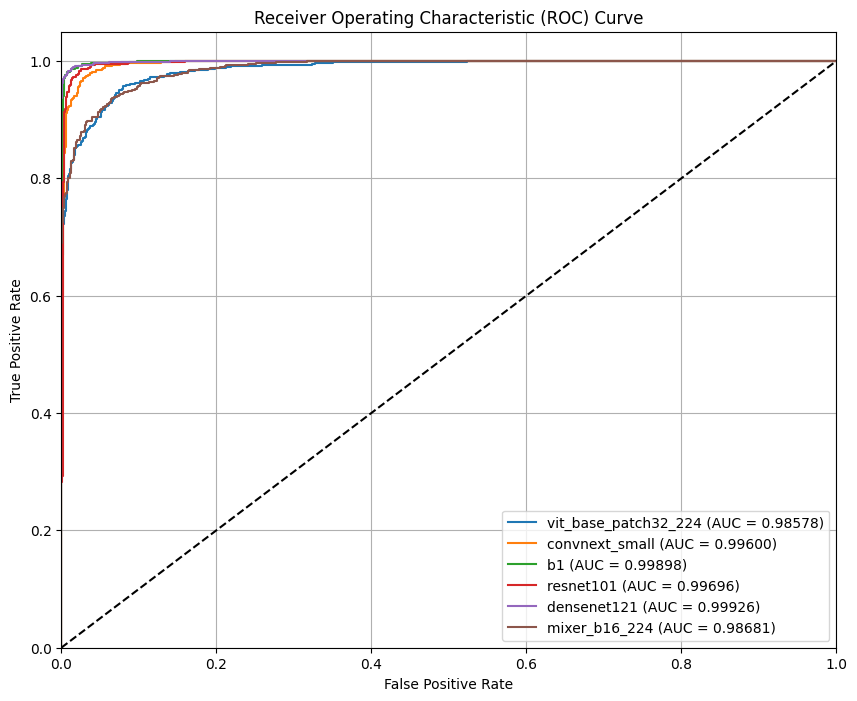

In [29]:
model_configs = {
    "vit_base_patch32_224" : {
        "feature_extraction": "vit_base_patch32_224",
        "decision_layer": "fc",
        "input_size": (224, 224),
        "data_dir": "data"
    },
    "convnext_small" : {
        "feature_extraction": "convnext_small",
        "decision_layer": "fc",
        "input_size": (224, 224),
        "data_dir": "data"
    },
    "b1" : {
        "feature_extraction": "efficientnet-b1",
        "decision_layer": "fc",
        "input_size": (240, 240),
        "data_dir": "data"
    },
    "resnet101": {
    "feature_extraction": "resnet101",
    "decision_layer": "fc",
    "input_size": [224, 224],
    "data_dir": "data"
    },
    "densenet121": {
        "feature_extraction": "densenet121",
        "decision_layer": "fc",
        "input_size": [224, 224],
        "data_dir": "data"
    },
    "mixer_b16_224": {
        "feature_extraction": "mixer_b16_224",
        "decision_layer": "fc",
        "input_size": [224, 224],
        "data_dir": "data"
    }
}

# mispredicted_indices = plot_roc_curves(model_configs, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))



{'vit_base_patch32_224': [12, 13, 14, 42, 43, 44, 55, 56, 57, 63, 64, 114, 115, 198, 247, 248, 249, 253, 254, 255, 260, 263, 269, 278, 316, 333, 334, 335, 342, 343, 344, 355, 364, 395, 405, 406, 425, 426, 427, 442, 443, 444, 457, 460, 461, 462, 463, 471, 472, 473, 474, 475, 476, 477, 480, 481, 482, 483, 486, 492, 541, 558, 559, 561, 562, 563, 576, 580, 632, 660, 661, 662, 687, 688, 689, 691, 693, 694, 696, 697, 698, 700, 703, 704, 708, 709, 711, 712, 714, 717, 718, 736, 747, 748, 749, 750, 751, 752, 831, 832, 849, 850, 851, 873, 874, 875, 880, 881, 901, 918, 919, 920, 1006, 1068, 1072, 1073, 1074, 1075, 1076, 1077, 1104, 1131, 1134, 1135, 1157, 1168, 1196, 1197, 1198, 1213, 1246, 1308, 1310, 1312, 1358, 1430, 1467, 1469, 1471, 1554, 1581, 1585, 1605, 1607], 'convnext_small': [56, 116, 135, 136, 137, 196, 197, 198, 218, 492, 548, 561, 562, 563, 600, 601, 602, 607, 615, 616, 617, 630, 669, 672, 702, 737, 748, 756, 758, 768, 769, 782, 831, 832, 833, 846, 847, 848, 849, 850, 851, 861, 862,

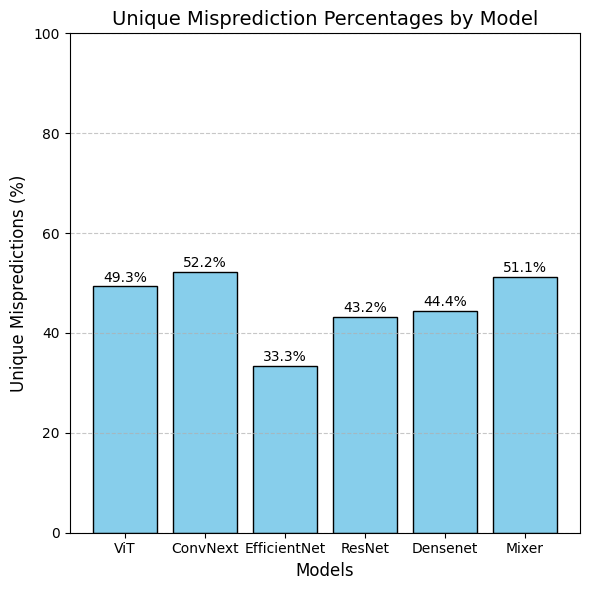

In [36]:
import re
print(mispredicted_indices)
def calculate_unique_mispredictions(mispredicted_indices):
    """
    Calculate which model has the highest percentage of unique mispredictions.
    
    Args:
        mispredicted_indices (dict): A dictionary where keys are model names and 
                                     values are lists of mispredicted indices for each model.
    
    Returns:
        dict: A dictionary containing the unique percentage for each model.
        str: The name of the model with the highest unique percentage.
    """
    from collections import defaultdict

    # Convert lists of indices to sets for efficient comparisons
    mispredicted_sets = {model: set(indices) for model, indices in mispredicted_indices.items()}
    
    # Initialize a dictionary to store unique counts and percentages
    unique_percentages = {}

    for model, mispredictions in mispredicted_sets.items():
        others = set()
        for other_model, other_mispredictions in mispredicted_sets.items():
            if model != other_model:
                others.update(other_mispredictions)
        

        unique_mispredictions = mispredictions - others
        unique_count = len(unique_mispredictions)
        total_count = len(mispredictions)
        
        unique_percentage = (unique_count / total_count * 100) if total_count > 0 else 0
        unique_percentages[model] = unique_percentage

    # Find the model with the highest percentage of unique mispredictions
    best_model = max(unique_percentages, key=unique_percentages.get)
    
    return unique_percentages, best_model

unique_percentages, best_model = calculate_unique_mispredictions(mispredicted_indices)
print(f"Model with the highest percentage of unique mispredictions: {best_model}")
print(f"Unique percentage: {unique_percentages[best_model]}%")
print(f"Unique percentages: {unique_percentages}")

def plot_unique_mispredictions(unique_percentages):
    """
    Plot a bar graph for the unique percentages of mispredictions for each model.
    
    Args:
        unique_percentages (dict): A dictionary where keys are model names and
                                   values are unique misprediction percentages.
    """
    # Extract model names and percentages
    models = list(unique_percentages.keys())
    for k in range(len(models)):
        if "vit" in models[k]:
            models[k] = "ViT"
        elif "convnext" in models[k]:
            models[k] = "ConvNext"
        elif "densenet" in models[k]:
            models[k] = "Densenet"
        elif "resnet" in models[k]:
            models[k] = "ResNet"
        elif "mixer" in models[k]:
            models[k] = "Mixer"
        elif "b" in models[k]:
            models[k] = "EfficientNet"
        else:
            clean_model = re.sub(r'[\d_]', '', models[k])
            models[k] = clean_model
    percentages = list(unique_percentages.values())

    # Create the bar plot
    plt.figure(figsize=(6, 6))
    plt.bar(models, percentages, color='skyblue', edgecolor='black')
    
    # Add labels, title, and grid
    plt.xlabel('Models', fontsize=12)
    plt.ylabel('Unique Mispredictions (%)', fontsize=12)
    plt.title('Unique Misprediction Percentages by Model', fontsize=14)
    plt.ylim(0, 100)  # Set y-axis to range from 0% to 100%
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add percentage values on top of the bars
    for i, value in enumerate(percentages):
        plt.text(i, value + 1, f"{value:.1f}%", ha='center', fontsize=10)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# plot_unique_mispredictions(unique_percentages)


In [57]:
class EnsembleModel(nn.Module):
    def __init__(self, model1, model2, model1_load_path, model2_load_path):
        super(EnsembleModel, self).__init__()
        print(model1_load_path, model2_load_path)
        saved = torch.load(model1_load_path)
        print(f"Loading weights from {model1_load_path}")
        # print(saved)
        if hasattr(saved, 'items') and 'model_state_dict' in saved:
            model1.load_state_dict(saved['model_state_dict'])
        else:
            model1 = saved['model']
        
        saved = torch.load(model2_load_path)
        print(f"Loading weights from {model2_load_path}")
        if hasattr(saved, 'items') and 'model_state_dict' in saved:
            model2.load_state_dict(saved['model_state_dict'])
        else:
            print("Here")
            model2 = saved['model']
        

        self.model1 = model1
        self.model2 = model2

    def forward(self, x):

        output1 = self.model1(x)  # Model 1 output (logits or softmax)
        output2 = self.model2(x)  # Model 2 output (logits or softmax)

        avg_output = (output1 + output2) / 2
        return avg_output

In [77]:
model_configs = {
    "ensemble" : {
    "model_1" : {
        "feature_extraction": "resnet101",
        "decision_layer": "fc",
        "input_size": (240, 240),
        "data_dir": "data"
    },
    "model_2" : {
        "feature_extraction": "convnext_small",
        "decision_layer": "fc",
        "input_size": (224, 224),
        "data_dir": "data"
        }
    },
    "ensemble2" : {
    "model_1" : {
        "feature_extraction": "resnet101",
        "decision_layer": "fc_base",
        "input_size": (240, 240),
        "data_dir": "data"
    },
    "model_2" : {
        "feature_extraction": "convnext_small",
        "decision_layer": "fc_base",
        "input_size": (224, 224),
        "data_dir": "data"
        }
    },
    "ensemble3" : {
    "model_1" : {
        "feature_extraction": "vit_base_patch32_224",
        "decision_layer": "fc_base",
        "input_size": (240, 240),
        "data_dir": "data"
    },
    "model_2" : {
        "feature_extraction": "efficientnet-b1",
        "decision_layer": "fc_base",
        "input_size": (224, 224),
        "data_dir": "data"
        }
    },
}

Processing ensemble...


c:\Users\Raulg\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Raulg\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


saved_models//resnet101 fc.pth saved_models//convnext_small fc.pth
Loading weights from saved_models//resnet101 fc.pth


C:\Users\Raulg\AppData\Local\Temp\ipykernel_31360\915577692.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved = torch.load(model1_load_path)
C:\Users\Raulg\AppData\L

Loading weights from saved_models//convnext_small fc.pth
Here
(224, 224)
Class 0: 50.00% of total samples
Class 1: 50.00% of total samples
Accuracy on Set:  0.993
AUC: 0.99966
Successfully plotted ensemble
Processing ensemble2...


c:\Users\Raulg\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Raulg\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


saved_models//resnet101 fc_base.pth saved_models//convnext_small fc_base.pth
Loading weights from saved_models//resnet101 fc_base.pth


C:\Users\Raulg\AppData\Local\Temp\ipykernel_31360\915577692.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved = torch.load(model1_load_path)
C:\Users\Raulg\AppData\L

Loading weights from saved_models//convnext_small fc_base.pth
Here
(224, 224)
Class 0: 50.00% of total samples
Class 1: 50.00% of total samples
Accuracy on Set:  0.642
AUC: 0.7614515000000001
Successfully plotted ensemble2


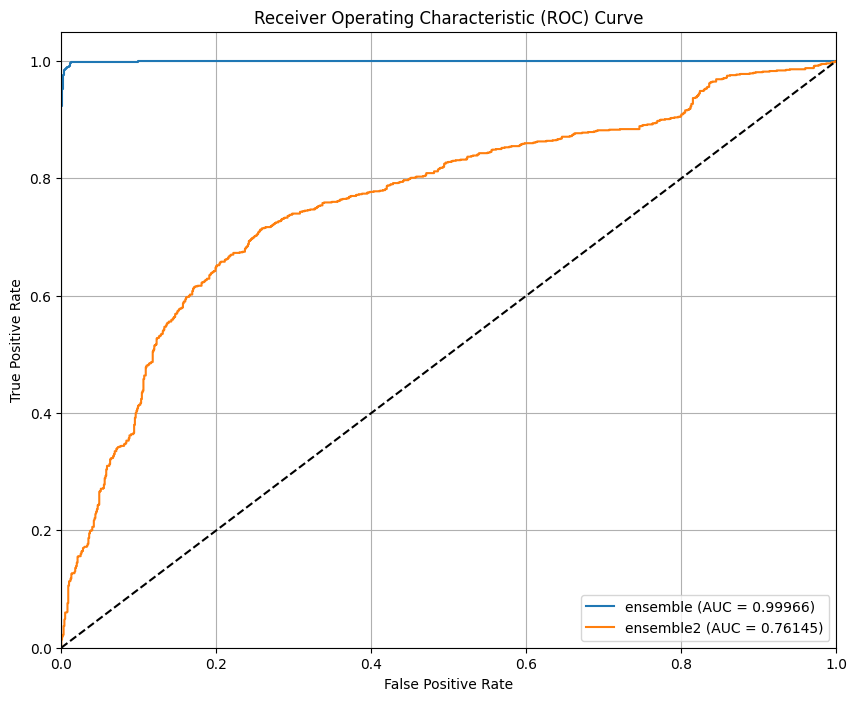

In [78]:
def plot_roc_curves_ensemble(model_configs, device):
    plt.figure(figsize=(10, 8))
    
    mispredicted_indices = {}  
    for model_name, config in model_configs.items():
        print(f"Processing {model_name}...")
        
        try:
            if 'convnext' in model_name:
                model = DeepfakeClassifier_timm(config["feature_extraction"], config["decision_layer"])
            elif 'vit' in model_name:
                model = DeepfakeClassifier_timm(config["feature_extraction"], config["decision_layer"])
            elif 'mixer' in model_name:
                model = DeepfakeClassifier_timm(config["feature_extraction"], config["decision_layer"])
            elif 'ensemble' in model_name:
                if 'convnext' in config["model_1"]["feature_extraction"]:
                    model1 = DeepfakeClassifier_timm(config["model_1"]["feature_extraction"], config["model_1"]["decision_layer"])
                elif 'vit' in config["model_1"]["feature_extraction"]:
                    model1 = DeepfakeClassifier_timm(config["model_1"]["feature_extraction"], config["model_1"]["decision_layer"])
                elif 'mixer' in config["model_1"]["feature_extraction"]:
                    model1 = DeepfakeClassifier_timm(config["model_1"]["feature_extraction"], config["model_1"]["decision_layer"])
                else:
                    model1 = DeepfakeClassifier(config["model_1"]["feature_extraction"], config["model_1"]["decision_layer"])
                if 'convnext' in config["model_2"]["feature_extraction"]:
                    model2 = DeepfakeClassifier_timm(config["model_2"]["feature_extraction"], config["model_2"]["decision_layer"])
                elif 'vit' in config["model_2"]["feature_extraction"]:
                    model2 = DeepfakeClassifier_timm(config["model_2"]["feature_extraction"], config["model_2"]["decision_layer"])
                elif 'mixer' in config["model_2"]["feature_extraction"]:
                    model2 = DeepfakeClassifier_timm(config["model_2"]["feature_extraction"], config["model_2"]["decision_layer"])
                else:
                    model2 = DeepfakeClassifier(config["model_2"]["feature_extraction"], config["model_2"]["decision_layer"])
                model_path1 = f"saved_models//{config['model_1']['feature_extraction']} {config['model_1']['decision_layer']}.pth"
                model_path2 = f"saved_models//{config['model_2']['feature_extraction']} {config['model_2']['decision_layer']}.pth"
                model = EnsembleModel(model1, model2, model_path1, model_path2)
            else:
                
                model = DeepfakeClassifier(config["feature_extraction"], config["decision_layer"])

            input_size = config.get('input_size', (224, 224))
            print(input_size)
            transform = transforms.Compose([
                transforms.Resize(input_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
            ])

            dataset = ImageFolder(config['model_1']['data_dir'], transform=transform)
            val_loader_model = DataLoader(dataset, batch_size=32, shuffle=False)
            
            class_counts = collections.Counter()

            for image, label in val_loader_model:
                class_counts.update(label.numpy())

            total_samples = sum(class_counts.values())
            for class_label, count in class_counts.items():
                percentage = count / total_samples
                print(f"Class {class_label}: {percentage:.2%} of total samples")
            
            if percentage != .5: 
                print("Rebalancing dataset")
                print(dataset.class_to_idx)
                real_indicies = [i for i, label in enumerate(dataset.targets) if label == dataset.class_to_idx['real']]
                fake_indicies = [i for i, label in enumerate(dataset.targets) if label == dataset.class_to_idx['fake']]
                num_real = len(real_indicies)
                num_fake = min(len(fake_indicies), num_real)
                print(f"Number of new real samples: {num_real}")
                print(f"Number of new fake samples: {num_fake}")
                limited_fake_indicies = np.random.choice(fake_indicies, num_fake, replace=False)
                real_subset = Subset(dataset, real_indicies)
                fake_subset = Subset(dataset, limited_fake_indicies)
                balanced_dataset = ConcatDataset([real_subset, fake_subset])
                val_loader_model = DataLoader(balanced_dataset, batch_size=32, shuffle=False)
            if "ensemble" not in model_name:
                model_path = f"saved_models//{config['feature_extraction']} {config['decision_layer']}.pth"
                saved = torch.load(model_path)
                print(f"Loading weights from {model_path}")
                # print(saved)
                if hasattr(saved, 'items') and 'model_state_dict' in saved:
                    model.load_state_dict(saved['model_state_dict'])
                else:
                    model = saved['model']
                    
                if hasattr(saved, 'items') and 'val_accuracy' in saved:
                    print(f"Validation accuracy: {saved['val_accuracy']}")
            
            model.to(device)
            model.eval()
            
            all_preds = []
            all_labels = []
            mispredicted_samples = [] 
            
            sample_index = 0  
            with torch.no_grad():
                for inputs, labels in val_loader_model:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs).squeeze()
                    
                    preds = torch.round(outputs) 
                    all_preds.extend(outputs.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # print(f"All predictions: {all_preds}")
                    # print(f"All outputs: {preds}")
                    # print(f"All labels: {all_labels}")
                    for i in range(len(labels)):
                        if preds[i].item() != labels[i].item(): 
                            # if i % 100 == 0:
                                # print(f"Mispredicted sample: {preds[i].item()}, {labels[i].item()}")
                            mispredicted_samples.append(sample_index + i)
                    
                    sample_index += len(labels)
            print("Accuracy on Set: ", (sample_index - len(mispredicted_samples))/ sample_index)
            mispredicted_indices[model_name] = mispredicted_samples
            
            # with torch.no_grad():
            #     for inputs, labels in val_loader_model:
            #         inputs, labels = inputs.to(device), labels.to(device)
            #         outputs = model(inputs).squeeze()
            #         all_preds.extend(outputs.cpu().numpy())
            #         all_labels.extend(labels.cpu().numpy())
            
            # Calculate ROC curve and AUC
            fpr, tpr, _ = roc_curve(all_labels, all_preds)
            roc_auc = auc(fpr, tpr)
            
            # Plot ROC curve
            print(f"AUC: {roc_auc}")
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.5f})')
            print(f"Successfully plotted {model_name}")

            
        except Exception as e:
            print(f"Error processing {model_name}: {str(e)}")
            continue
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    return mispredicted_indices

mispredicted_indices = plot_roc_curves_ensemble(model_configs, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
